# Kernel Density Estimation with Mixture of Gaussians

## Background
Density estimation is an algorithm which takes a D-dimensional dataset and estimates the D-dimensional probability distribution from which this dataset was sampled. Gaussian Mixture Models (GMMs) are density estimation algorithms where the estimated distribution is presumed to be a weighted sum of Gaussian distributions. Kernel Density Estimation is in some sense the algorithm which takes the Gaussian mixture to an extreme where each data point in the dataset corresponds to a Gaussian component, resulting in a non-parametric estimator of density.

The task at hand, is to use two popular datasets to model their probability distribution using the Kernel Density Estimation technique. For this excercise, MINST and CIFAR100 datasets are used to fit the model. This notebook covers the setup, preprocessing and model estimation steps for both these standard datasets and presents some key observations towards the end.


In [1]:
import os
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tarfile
import time
import pandas as pd
import urllib

## 1. Setup

    a. Download the datasets from URL and house them in './data' folder.
    b. Set the random seed to ensure reproduction of results obtained.
    c. Initialize dataset and results pandas dataframe containers.

 

In [2]:
cifar_url       = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
minst_url       = "http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz"
cifar_file      = "data/cifar-100-python.tar.gz"
cifar_dir       = "data/cifar-100-python"
minst_file      = "data/mnist.pkl.gz"

if not os.path.exists('data'):
    os.mkdir('data')

if not os.path.exists(minst_file):
    urllib.request.urlretrieve(minst_url, minst_file)

if not os.path.exists(cifar_file):
    urllib.request.urlretrieve(cifar_url, cifar_file)

# Initialize experiment params and data containers:
sigma_grid      = np.array([0.05, 0.08, 0.1, 0.2, 0.5, 1., 1.5, 2]).astype(np.float32)
datasets        = pd.DataFrame(columns = ['Dataset','Train','Test','Validation'])
search_results  = pd.DataFrame(columns = ['Dataset','Sigma', 'LogLikelihood', 'Time (sec)'])
test_results    = pd.DataFrame(columns = ['Dataset','Sigma', 'LogLikelihood', 'Time (sec)'])

# Set seed:
np.random.seed(0)

## 2. Data Loading & Preprocessing

In this section, data will be loaded from the datasets downloaded and pre-processed to fit the format required by downstream tasks.
The following functions are defined to be used in this section:

____resample____
Performs random shuffle of the input datastore and selects the first 10,000 samples as the new training dataset, the next 10,000 samples as a validation set. Rest of the data points are discarded.

__load_cifar__
Loads a CIFAR100 dataset batch file and preprocesses the images to normalize image intensities in [0 1] range. Returns the RGB images as a dataset of N-by-d array of N samples along the rows and pixel data laid out in columns.

__makegrid__
Assembles a X-by-Y grid of the first X * Y images from the input dataset.Returns a M-by-N-by-C image with subregions containing the sample images. C = number of image channels.
        
__rgb2gray__
Converts RGB dataset to its grayscale representation. This is used on the CIFAR100 dataset prior to feature extraction.

Insight into the data structures used in this section:

        1. Raw datasets loaded from the files are arranged as a tuple of (images, labels) where:
                images  -  N-by-d numpy array with N samples and d pixels/features
                labels  -  N-by-1 respective ground trutht labels


In [3]:
def __resample__(dataset):
    # Resampling train and validation set from the original training set:
    # Policy: 
    #   * First 10K samples are train.
    #   * Next 10K are validation. 
    #   * Rest are discarded.

    # Randomly permute the training set:
    num_samples = dataset[0].shape[0]
    index = np.random.permutation(num_samples)
    
    # In-place shuffle to save memory:
    np.take(dataset[0], index, axis=0, out=dataset[0])
    np.take(dataset[1], index, axis=0, out=dataset[1])

    # Assign train and validation sets:
    train = (dataset[0][0:10000], dataset[1][0:10000])
    valid = (dataset[0][10000:20000], dataset[1][10000:20000])

    return train, valid

def makegrid(dataset, x_grid=20, y_grid=20, num_channels=1):
    # Number of samples and pixels in image:
    num_samples, num_pixels = dataset.shape

    # Images are always M-by-M-by-C matrices flattened out. Reshape for display.
    M = int(np.sqrt(num_pixels/num_channels))
    images = dataset.reshape((num_samples,M,M,-1))
    images = images[:int(x_grid * y_grid)]

    # Initialize the grid with enough pixels to hold all images + 1 pixel border in each spatial 
    # dimension for image separation on the grid.
    grid = np.zeros((x_grid*M + M-1, 
                     y_grid*M + M-1, 
                     num_channels), images.dtype)
    
    # Insert images into the grid:
    positions = itertools.product(range(x_grid), range(y_grid))
    for (x_ind, y_ind), img in zip(positions, images):
        x = x_ind * (M + 1)
        y = y_ind * (M + 1)
        grid[y:y+M, x:x+M, :] = img

    return np.squeeze(grid)

def load_cifar(file):
    # Check if the dataset exists on path:
    cifar_dir  = "data/cifar-100-python"

    # Unpickle the dataset and resample to form training and validation datasets:
    batch = open(os.path.join(cifar_dir, file), 'rb')
    dict  = pickle.load(batch, encoding='bytes')

    # CIFAR100 data is organized as sequential color data. i.e., R,G,B values are laid out as 
    # a set of three 1-by-N patches. Parse this to expected format:
    images = dict[b'data']
    rgb = np.stack([images[:,:1024],     # Red channel
                    images[:,1024:2048], # Green channel
                    images[:,2048:]],    # Blue channel
                    axis=2)
    rgb = rgb.reshape((images.shape[0],-1))
    rgb = rgb/255 # Normalize to [0 1]
    set = (rgb, np.array(dict[b'coarse_labels']))

    return set

def rgb2gray(dataset):
    # Reshape dataset to N-by-M-by-M-by-3:
    N, num_pixels = dataset.shape
    M = int(np.sqrt(num_pixels/3))
    rgb  = dataset.reshape((N, M, M,-1))
    gray = rgb[:,:,:,0] * 0.2989 + rgb[:,:,:,1] * 0.5870 + rgb[:,:,:,2] * 0.1140

    # Return the grayscale N-by-(M*M) array:
    gray = gray.reshape(N,-1)

    return gray

### MINST Dataset

MINST is a dataset of handwritten digit images containing 28-by-28 grayscale images and corresponding training labels. The image intensities are already scaled to the {0, 1} range, so this pre-processing step is ignored while preparing this dataset. The downloaded file is read using pickle to unpack the image pixel data and labels. After reading, random shuffle and resampling is done to construct the train and validation sets. The test dataset is used as is.

In [4]:
# Open the file and read the dataset:
with gzip.open(minst_file, 'rb') as minst_zip:
    minst_train, minst_valid, minst_test = pickle.load(minst_zip, encoding='latin1')

# NOTE: MINST data is already normalized to [0 1], so skip this step.
minst_train, minst_valid = __resample__(minst_train)

### CIFAR 100 Dataset

The CIFAR-100 dataset contains 60,000 images composed of 600 images from 100 classes. Each image is a 32-by-32-by-3 RGB image. The dataset is distributed in as a tar file which is unpacked and extracted into a directory before loading data from the train and test batch files of the dataset. The train batch file is a pickle file that contains 50,000 training images with labels, and the test batch has 10,000 images. Similar to MINST, after extracting the training samples, random shuffling and resampling is performed to construct the train and validation sets. Test dataset is left untouched.

In [5]:
# Unzip the archive into the CIFAR100 sub-directory:
tar = tarfile.open(cifar_file)
tar.extractall("data")
tar.close()

# Load test and training datasets:
cifar_train = load_cifar('train')
cifar_test  = load_cifar('test')

# Resample train and validation sets:
cifar_train, cifar_valid = __resample__(cifar_train)

### Preview MINST & CIFAR100 Datasets

A grid of 20-by-20 images is constructed from the sampled training set that is used to preview the images in the dataset.

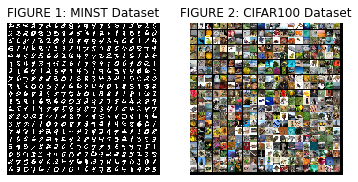

In [6]:
# Prepare preview grids for both the datasets:
minst_grid = makegrid(minst_train[0], num_channels=1)
cifar_grid = makegrid(cifar_train[0], num_channels=3)

fig, (ax1, ax2) = plt.subplots(1,2)

# Show MINST:
ax1.imshow(minst_grid > 0.1, interpolation='none', cmap=plt.cm.binary_r)
ax1.axis('off')
ax1.set_title('FIGURE 1: MINST Dataset')

# Show CIFAR100:
ax2.imshow(cifar_grid, interpolation='none')
ax2.axis('off')
ax2.set_title('FIGURE 2: CIFAR100 Dataset')

plt.show()

### Project Data onto Principal Components

Raw pixel data from a natural image are uncorrelated and therefore not suitable features for estimation. So, Principal Component Analysis is performed on the datasets to estimate the principal components that best 'describe' these datasets. Since CIFAR100 contains RGB images, they are converted to grayscale before performing PCA. Another adavantage of using PCA is to reduce the dimensionality of the problem. Since PCA projects original data from the images to a new D-dimensional space, where D = number of components selected, the kernel densities modeled are also reduced to D-dimensions. This reduces the computation time downstream.

In [7]:
class PCA():
    def __init__(self, num_components=15):
        self.num_components = 15
        self.components = None

    def fit(self, features):
        num_samples, num_features = features.shape

        # mean center data:
        features -= np.mean(features, axis=0)
        
        # SVD decomposition:
        U, sigma, coeff = np.linalg.svd(features, full_matrices=False)

        # Principal components are the coefficents (Vt)
        self.components = coeff[:self.num_components]

    def transform(self, features):
        reduced = np.dot(features, self.components.T)
        return reduced

In [8]:
# Fit PCA to its principal component space:
minst_pca = PCA()
minst_pca.fit(minst_train[0])

# Create training, validation and test feature sets and append to the dataframe:
datasets = datasets.append({
    'Dataset'   : "MINST",
    'Train'     : minst_pca.transform(minst_train[0]),
    'Test'      : minst_pca.transform(minst_test[0]),
    'Validation': minst_pca.transform(minst_valid[0])
}, ignore_index=True)

# Do, the same for CIFAR100 dataset, but CIFAR 100 is an RGB dataset, so convert to gray
# before projecting onto the principal component space. This ensures that each feature in
# the original space is represented by a single intensity value.
cifar_train_gray = rgb2gray(cifar_train[0])
cifar_test_gray  = rgb2gray(cifar_test[0])
cifar_valid_gray = rgb2gray(cifar_valid[0])

cifar_pca = PCA()
cifar_pca.fit(cifar_train_gray)

datasets = datasets.append({
    'Dataset'   : "CIFAR100",
    'Train'     : cifar_pca.transform(cifar_train_gray),
    'Test'      : cifar_pca.transform(cifar_test_gray),
    'Validation': cifar_pca.transform(cifar_valid_gray)
}, ignore_index=True)

### Inspect Principal Component Space

After projecting the data onto the component space, data is inspected using the ground truth labels to identify whether the clusters are separable in the plane spanned by the first two principal components. Looking at the plot below, it is evident that PCA helps achieve separability in MINST, while CIFAR100 data does not contain well defined clusters. This will likely affect density estimates.

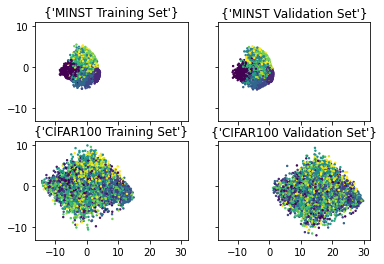

In [9]:
# Prepare validation set using training components:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()

labels = (minst_train[1], minst_valid[1], cifar_train[1], cifar_valid[1])
for index, row in datasets.iterrows():
    # Plot training features in PC space:
    axes[index*2].scatter( row['Train'][:,0], row['Train'][:,1], c = labels[index*2], s = 2 )
    axes[index*2].set_title({"{0} Training Set".format(row['Dataset'])})

    # Plot validation features in same space:
    axes[index*2+1].scatter( row['Validation'][:,0], row['Validation'][:,1], c = labels[index*2+1], s = 2  )
    axes[index*2+1].set_title({"{0} Validation Set".format(row['Dataset'])})

plt.show()

## 3. Log Likelihood Estimation

### Estimate Log Likelihood of Validation Set Under Training Data

So far, data is loaded from the file scaled, sampled and projected into a principal component space to conclude feature extraction. In this section, we will use the features derived after PCA in performing Kernel Density Estimation. A brief overview of this model which tries to estimate the log-likelihood of the dataset B under another dataset A:

Each sample in A is assumed to be a gaussian mixing component with uniform prior probability i.e., the probability of a sample in B belonging to either of the samples in A is assumed uniform (1/k), where k = number of samples in A. The gaussian components of samples in A are centered at the sample observed, uniformly weighted across A, and are all assumed to have the same bandwidth parameter 'sigma'. Therefore, the likelihood of a sample from B belonging to the split A is simply put the sum of all probabilities of the 'closeness' of the sample to all samples in A, under a given 'sigma'. This closeness is modeled by the euclidean distance between the feature vectors in both sets. If the distance is large, the density at that gaussian component is low and vice-versa.

The log-likelihood of the entire dataset B is simply computed as the average of the log-likelihood of all the individual samples in the set.

            log_density  -   Computes the log-likelihood of a setB under setA for a given bandwidth parameter 'sigma'. This function returns a vector                              values that are the log-density estimate for each data point in setB.


In [10]:
def log_density(setB, setA, sigma):
    # Precompute some constants:
    k, d  = setA.shape
    sigma_sqr  = sigma ** 2
    norm_const = 0.5 * np.log(2 * np.pi * sigma_sqr) * d
    prior = np.log(1/k)

    likelihood = np.zeros((setA.shape[0],)).astype(np.float64)

    for ind, sample in enumerate(setB):
        # Now, compute the distance of the sample from the mean of each gaussian kernel 
        # assumed on training set datapoints.
        sample = np.tile(sample, (k, 1))
        distance = np.square(sample - setA) / (2 * sigma_sqr)

        # Compute log likelihood:
        # NOTE: -88 is hardcoded to prevent exponent overflow. This can be handled better.
        #       This has the sideeffect of saturating the lowest possible likelihood.
        prob = np.exp(np.clip(prior - norm_const - np.sum(distance, axis=1), -88, None))
        likelihood[ind] = np.log(prob.sum())

    return likelihood

### Grid Search

In estimating the optimal bandwith parameter for each dataset, we compute the log-likelihood of their validation set under the training set by varying the bandwith 'sigma' over a fixed set of values. The optimal parameter for respective datasets is the value that attains the maximum log-likelihood of the validation set under training data.

    Sigma values searched: {0.05, 0.08, 0.1, 0.2, 0.5, 1., 1.5, 2}

In [11]:
# Iterate over both the datasets and find the optimal bandwidth for each set:
for index, row in datasets.iterrows():
    for sigma in sigma_grid:
        start_time = time.time()
        density    = log_density(row['Validation'], row['Train'], sigma)
        exe_time   = time.time() - start_time

        # Append to the results dataframe:
        search_results = search_results.append({
            'Dataset'       : row['Dataset'],
            'Sigma'         : sigma, 
            'LogLikelihood' : density.sum()/density.shape,
            'Time (sec)'    : exe_time
        }, ignore_index=True)

print(search_results)

     Dataset  Sigma          LogLikelihood  Time (sec)
0      MINST   0.05   [-78.78965759277344]    8.712524
1      MINST   0.08   [-78.78965759277344]    6.363568
2      MINST   0.10   [-78.78965759277344]    6.592662
3      MINST   0.20   [-78.61373173732757]    6.575555
4      MINST   0.50   [-43.87355021286011]    6.348649
5      MINST   1.00  [-29.971540872573854]    5.825978
6      MINST   1.50   [-30.35268921394348]    5.390427
7      MINST   2.00  [-31.736580742645263]    5.437881
8   CIFAR100   0.05   [-78.78965962802383]    9.344335
9   CIFAR100   0.08   [-78.78675377980242]    8.834555
10  CIFAR100   0.10   [-78.74301341261233]    8.330678
11  CIFAR100   0.20   [-76.12436217857409]    8.133990
12  CIFAR100   0.50   [-53.82166617472225]    8.156883
13  CIFAR100   1.00   [-38.28358522321727]    8.091392
14  CIFAR100   1.50  [-34.814971970925676]    8.083299
15  CIFAR100   2.00   [-34.80100601257513]    8.206939


From grid search results, it is evident that the optimal value for sigma for MINST and CIFAR100 datasets are 1 and 2 respectively. Using this we calculate the log likelihood of the test set. The larger bandwidth of CIFAR100 is not surprising here. Tracking back, the principal component projection of the CIFAR100 dataset did not give enough separation between the clusters unlike MINST, so the fit will be more generalized and therefore accepting more variance.

In [12]:
sigma_opt  = [1, 2]
for index, row in datasets.iterrows():
    start_time = time.time()
    density = log_density(row['Test'], row['Train'], sigma=sigma_opt[index])
    exe_time   = time.time() - start_time

    # Append to the results dataframe:
    test_results = test_results.append({
            'Dataset'       : row['Dataset'],
            'Sigma'         : sigma_opt[index], 
            'LogLikelihood' : density.sum()/density.shape,
            'Time (sec)'    : exe_time
        }, ignore_index=True)

print(test_results)

    Dataset Sigma          LogLikelihood  Time (sec)
0     MINST     1  [-30.119775206756593]    5.951894
1  CIFAR100     2   [-34.85859716206363]    8.857087


## 4. Observations

Plot the grid search results to observe the trend in how the bandwidth parameter affects likelihood scores.

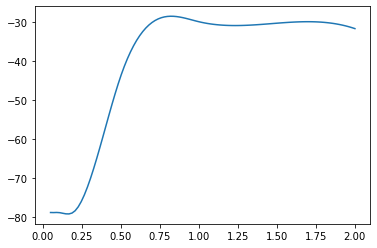

In [13]:
from scipy import interpolate

row = search_results.query('Dataset == "MINST"')
y = row['LogLikelihood']
x = row['Sigma']

x_smooth = np.linspace(x.min(), x.max(), 100)
spline   = interpolate.make_interp_spline(x,y)
y_smooth = spline(x_smooth)

plt.plot(x_smooth, y_smooth)

This plot concurs with the intuition behild the bandwidth parameter. A very narrow bandwidth parameter models a very thin gaussian kernel around the training data points. Therefore, the kernel density of the data point allows for a very small variance from the actual sample. This explains the poor score for really small kernel densities. In essense, the model is over-fitted.

As the bandwidth increases, the distribution opens up to variations in data points, which improves the likelihood estimate. However, as we keep increasing this further, this smoothens the density modeled accepting large variance in data, thereby under-fitting the data. This naturally affects the likelihood score which begins to fall close to 2 for MINST.

So the optimal bandwidth selected using this cross-validation maximum likelihood estimate is '1' for MINST and '2' for CIFAR100 data.

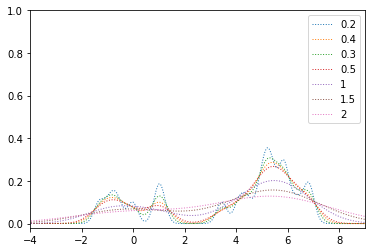

In [14]:
from sklearn.neighbors import KernelDensity
x = np.concatenate((np.random.normal(0, 1, int(0.3 * 20)),
                    np.random.normal(5, 1, int(0.7 * 20))))[:, np.newaxis]
x_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

fig, ax = plt.subplots()
for sigma in {0.2, 0.3, 0.4, 0.5, 1, 1.5, 2}:
    kde = KernelDensity(kernel='gaussian', bandwidth=sigma).fit(x)
    log_dens = kde.score_samples(x_plot)
    ax.plot(x_plot[:, 0], np.exp(log_dens), lw=1, linestyle=':', label=sigma)

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 1)
ax.legend()
plt.show()

As, we can see in the plot above which is estimated using KernelDensity function of sklearn, the density modeled for a multi-modal gaussian mixture is best represented by the bandwidth selection 0.5. For a low bandwidth, the density showcases more modalities and for a large bandwidth, the density is too smooth making the estimate unimodal.

Kernel Density Estimates work well when the dataset has enough samples to model the distrubution accurately. When the sample size is small, the estimates are pro


### Performance

The performance of the function the log_density function which computes the log likelihood of the setB under setA, as bechmarked on my 4-core intel 2016 Macbook pro is shown below. Performance can further be improved through parallel processing the log-likelihood over all available cores in a pool, since likelihood of samples is independent of other samples in the dataset.

In [15]:
row = datasets.query('Dataset == "MINST"')
%timeit log_density(datasets.Validation[0], datasets.Train[0], sigma=1)

5.44 s ± 79.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
